## Import

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import zipfile
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

## Parsing the Data

In [3]:
with open('data/data.json') as i:
  data = json.load(i)

In [4]:
#getting all the data to lists
tags = []
inputs = []
responses = {}
for intent in data['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [5]:
#converting to dataframe
data = pd.DataFrame({
    "inputs":inputs,
    "tags":tags
    })
print("Data Shape\nrow: %d\ncolumns: %d"%(data.shape[1], data.shape[0]))
data.head(10)

Data Shape
row: 2
columns: 1056


,inputs,tags
0,hello,greeting
1,halo,greeting
2,hola,greeting
3,hey,greeting
4,hoy,greeting
5,yo,greeting
6,ahoy,greeting
7,sup,greeting
8,hey there,greeting
9,hi,greeting


## Train Test Split

In [6]:
# Global Variable
sentences = data['inputs']
labels = data['tags']
train_size = 0.8
EMBEDDING_DIM = 100
MAXLEN = 11
TRUNCATING = 'post'
PADDING = 'post'

In [7]:
from sklearn.model_selection import train_test_split


def train_val_split(sentences, labels, train_size):
    train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(
        sentences, labels, train_size=train_size, random_state=10)
    return train_sentences, validation_sentences, train_labels, validation_labels


In [8]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(
    sentences, labels, train_size)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")


There are 844 sentences for training.

There are 844 labels for training.

There are 212 sentences for validation.

There are 212 labels for validation.


## Data Cleaning

#### Removing Punctuations

In [9]:
train_sentences = train_sentences.apply(
    lambda wrd: [ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_sentences = train_sentences.apply(lambda wrd: ''.join(wrd))

train_sentences.head(10)

989                                                ok bye
802                   tell me how to refund flight ticket
924                           how to regain travel credit
504     where i can get information about reschedule h...
661                              hotel ticket cancelation
104                credit card transaction not successful
828                  whats the call center contact number
524                   i think i wanna reschedule my hotel
750                                cancel boarding ticket
1046                                         im impressed
Name: inputs, dtype: object

#### Tokenizer

In [10]:
def fit_tokenizer(data, oov_token):
  # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
  tokenizer = Tokenizer(num_words=1000, oov_token=oov_token)

  # Fit the tokenizer to the training sentences
  tokenizer.fit_on_texts(data)

  return tokenizer


In [11]:
tokenizer = fit_tokenizer(train_sentences, "<OOV>")

word_index = tokenizer.word_index
vocab_size = len(word_index)
print("number of unique words: ", vocab_size)

number of unique words:  402


#### Sequences, truncating and padding

In [12]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):

    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences, )

    # Pad the sequences using the correct padding, truncating and maxlen
    x_train = pad_sequences(sequences, maxlen=maxlen,
                            padding=padding, truncating=truncating)

    return x_train


In [13]:
train_pad_trunc_seq = seq_pad_and_trunc(
    train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(
    val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(
    f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(
    f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")


Padded and truncated training sequences have shape: (844, 11)

Padded and truncated validation sequences have shape: (212, 11)


In [14]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

#### Encoding

In [15]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.fit_transform(val_labels)

In [16]:
tags_unique_length = le.classes_.shape[0]
print("number of tags: ", tags_unique_length)


number of tags:  13


## Embedding

In [ ]:
# download it
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

In [ ]:
with zipfile.ZipFile('tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('tmp/glove')

In [17]:
# Define path to file containing the embeddings
GLOVE_FILE = 'tmp/glove/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [18]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

## Modelling

In [52]:
def create_nlp_model(vocab_size, output_length, embedding_dim, embedding_matrix, maxlen):

  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size+1, embedding_dim,
                                input_length=maxlen, weights=[embedding_matrix], trainable=True),
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(64,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(
          1e-6), activity_regularizer=tf.keras.regularizers.L1(1e-6)),
      tf.keras.layers.Dropout(0.009),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(
          1e-6), activity_regularizer=tf.keras.regularizers.L2(1e-6)),
      tf.keras.layers.Dropout(0.008),
      tf.keras.layers.Dense(output_length, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])
  return model


In [53]:
model = create_nlp_model(vocab_size, tags_unique_length,
                         EMBEDDING_DIM, EMBEDDINGS_MATRIX, MAXLEN)
                         
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 11, 100)           40300     
                                                                 
 bidirectional_14 (Bidirecti  (None, 11, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 16)               

In [54]:
history = model.fit(train_pad_trunc_seq, train_labels,
                    epochs=50, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/50
27/27 [==============================] - 7s 81ms/step - loss: 2.5621 - accuracy: 0.0972 - val_loss: 2.5466 - val_accuracy: 0.0849
Epoch 2/50
27/27 [==============================] - 2s 57ms/step - loss: 2.5300 - accuracy: 0.1043 - val_loss: 2.5206 - val_accuracy: 0.1132
Epoch 3/50
27/27 [==============================] - 1s 52ms/step - loss: 2.4968 - accuracy: 0.1410 - val_loss: 2.4837 - val_accuracy: 0.1274
Epoch 4/50
27/27 [==============================] - 1s 51ms/step - loss: 2.4523 - accuracy: 0.1635 - val_loss: 2.4296 - val_accuracy: 0.2170
Epoch 5/50
27/27 [==============================] - 1s 47ms/step - loss: 2.3967 - accuracy: 0.2073 - val_loss: 2.3649 - val_accuracy: 0.2453
Epoch 6/50
27/27 [==============================] - 1s 47ms/step - loss: 2.3161 - accuracy: 0.2618 - val_loss: 2.2749 - val_accuracy: 0.2642
Epoch 7/50
27/27 [==============================] - 1s 44ms/step - loss: 2.2124 - accuracy: 0.2832 - val_loss: 2.1617 - val_accuracy: 0.3019
Epoch 8/50
27

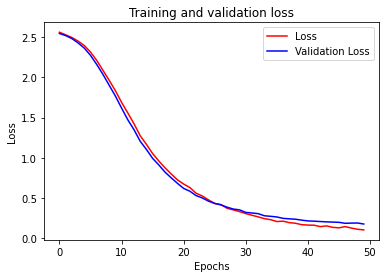

In [55]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(loss, 'r')
plt.plot(val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()


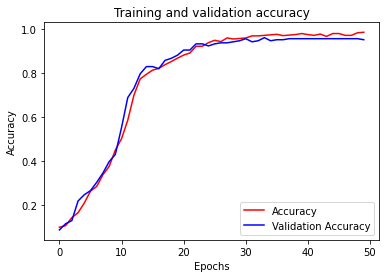

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(acc, 'r')
plt.plot(val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()


## Save Model

In [ ]:
# # with pickle
# import pickle
# pickle.dump(model, open('model.pkl', 'wb'))

# # with keras
# model.save("model/model.h5")